## SageMaker SHAP heatmap test

In [1]:
import pickle
import matplotlib.pyplot as plt
import matplotlib.style as style
import matplotlib.dates as mdates
import matplotlib.cm as cm
from matplotlib.colors import LinearSegmentedColormap

from itertools import repeat, chain
import seaborn as sns
import numpy as np
import pandas as pd
import sklearn
import time

from sklearn.metrics import mean_squared_error, mean_absolute_error
import lightgbm
from lightgbm import LGBMRegressor
import shap
import scipy.sparse
import copy

style.use('seaborn-v0_8-ticks')
plt.rcParams.update({'figure.facecolor':'white'})
sns.set_theme(style="ticks")

import os
from pathlib import Path

# Store the original directory path in a global variable if it doesn't exist yet
if not hasattr(__builtins__, '_original_dir'):
    __builtins__._original_dir = os.getcwd()
    root_dir = Path(__builtins__._original_dir).resolve().parent
    os.chdir(root_dir)
    print(f"Changed working directory to: {os.getcwd()}")
else:
    print(f"Directory already changed. Current working directory: {os.getcwd()}")

from utils.data_preparation import preprocess_data, split_data, mapping
from processing.custom_metrics import nash_sutcliffe, kling_gupta

%matplotlib inline

Changed working directory to: C:\Users\xkorpijo3\OneDrive - Fortum\Desktop\Master-thesis-GBRT-dam


In [2]:
color = '\033[1m\033[38;5;208m' 
print(f"{color}Version scikit-learn: {sklearn.__version__}")
print(f"{color}Version lightgbm: {lightgbm.__version__}")
print(f"{color}Version SHAP: {shap.__version__}")
print(f"{color}Version pandas: {pd.__version__}")
print(f"{color}Version numpy: {np.__version__}")
print(f"{color}Version seasborn: {sns.__version__}")

Version scikit-learn: 1.5.2
Version lightgbm: 4.5.0
Version SHAP: 0.46.0
Version pandas: 2.2.3
Version numpy: 1.26.4
Version seasborn: 0.13.2


### **Define model type of the analysis**

In [3]:
model_name = 'LightGBM'

### **Define target of analysis**

In [4]:
target = 'MB4'

In [6]:
features = ['GV1', 'GV3', 'GV51', 'MB4', 'MB8', 'MB10', 'MB18',
            'h', 'h_MA_060', 'h_MA_180',
            'TA', 'TA_MA_180', 'TA_lag_060', 'TA_lag_090', 
            'P', 'P_RS_180',
            'Q', 'Q_RS_030', 'Q_RS_120',
            't', 'month']

all_features_grouped = {
    'Reservoir level': ['h', 'h_MA_060', 'h_MA_180',],
    'Air Temperature': ['TA', 'TA_MA_180'],
    'Lagged Air Temperature': ['TA_lag_060', 'TA_lag_090'],
    'Precipitation': ['P', 'P_RS_180'],
    'Local Inflow': ['Q', 'Q_RS_090', 'Q_RS_180'],
    'Time-related features': ['t', 'month'],
    'GV1': ['GV1'], 
    'GV3': ['GV3'], 
    'GV51': ['GV51'],
    'MB4': ['MB4'], 
    'MB8': ['MB8'], 
    'MB10': ['MB10'],
    'MB18': ['MB18']
}

feature_categories = {
    'Response': ['GV1', 'GV3', 'GV51', 'MB4', 'MB8', 'MB10', 'MB18'],
    'Environmental': ['h', 'h_MA_060', 'h_MA_180',
                     'TA', 'TA_MA_180', 'TA_lag_060', 'TA_lag_090', 
                     'P', 'P_RS_180',
                     'Q', 'Q_RS_030', 'Q_RS_120',
                     't', 'month']
}

features_derived = {
    'Original': ['GV1', 'GV3', 'GV51', 'MB4', 'MB8', 'MB10', 'MB18', 'h', 'TA', 'P', 'Q'],
    'Environmental': ['h_MA_060', 'h_MA_180',
                     'TA_MA_180', 'TA_lag_060', 'TA_lag_090', 
                     'P_RS_180',
                     'Q_RS_030', 'Q_RS_120',
                     't', 'month']
}

In [7]:
test_size = 0.2
poly_degree = 0

if target in features: features.remove(target)
if target in all_features_grouped: del all_features_grouped[target]
path = f'./data/LOS_DAMM_{mapping(target)}.csv'
data = pd.read_csv(path, sep=';', parse_dates=['Date-Time'])

# Extract start and end dates
dates = data['Date-Time']
start_date = dates.iloc[0].date()  # First date (YYYY-MM-DD)
end_date = dates.iloc[-1].date()  # Last date (YYYY-MM-DD)

# Preprocess the data (You would need to define preprocess_data elsewhere in your code)
X, y, dates = preprocess_data(features, target, start_date, end_date, poly_degree=poly_degree, test_size=test_size)

# Split the data into training and testing sets (Assumes split_data is defined elsewhere)
X_train, X_test, y_train, y_test, split_index = split_data(X, y, test_size=test_size)

print("data loaded")

with open(f'./visualization/models/{model_name}/{model_name}_model_{target}.pkl', 'rb') as f:
    model = pickle.load(f)

print(f"{target} model loaded")

data loaded
MB4 model loaded


In [8]:
model.fit(X_train, y_train)
# Linear_tree=True works as well!!!

LGBMRegressor(colsample_bytree=0.9169225803001793,
              learning_rate=0.006305086838580839, linear_tree=False,
              max_depth=12, min_child_samples=101,
              min_split_gain=0.001347092605256956, n_estimators=2469,
              num_leaves=24, reg_alpha=0.0005033311938044666,
              reg_lambda=0.004161142801434803, subsample=0.28568037942748326,
              verbose=-1)

#### Sanity check that model is correct and predicts well

In [9]:
feature_names = X_train.columns
print(feature_names)

train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)
all_predictions = model.predict(X)

rmse_train = np.sqrt(mean_squared_error(y_train, train_predictions))
rmse_test = np.sqrt(mean_squared_error(y_test, test_predictions))
mae_test = mean_absolute_error(y_test, test_predictions)
NSE_test = nash_sutcliffe(y_test, test_predictions)
KGE_test = kling_gupta(y_test, test_predictions)

print("RMSE Train:", rmse_train)
print("RMSE Test:", rmse_test)
print("MAE Test:", mae_test)
print("NSE Test:", NSE_test)
print("KGE Test:", KGE_test)

Index(['t', 'month', 'GV1', 'GV3', 'GV51', 'MB8', 'MB10', 'MB18', 'h',
       'h_MA_060', 'h_MA_180', 'TA', 'TA_MA_180', 'TA_lag_060', 'TA_lag_090',
       'P', 'P_RS_180', 'Q', 'Q_RS_030', 'Q_RS_120'],
      dtype='object')
RMSE Train: 0.5634588782293226
RMSE Test: 1.1650104706615172
MAE Test: 0.8523018120387068
NSE Test: 0.9295457156204978
KGE Test: 0.9525106118995883


# SHAP HEATMAP

In [ ]:
previous_year_X_train = X[split_index-len(X_test):split_index]

# Get feature names from your DataFrame
feature_name = X.columns.tolist()

In [ ]:
explainer = shap.TreeExplainer(model, feature_perturbation='interventional', data=np.array(previous_year_X_train), feature_names=feature_name)
shap_test = explainer(np.array(X_test), check_additivity=False)

100%|===================| 8026/8031 [14:25<00:00]        

In [ ]:
previous_year_y_train = y[split_index-len(X_test):split_index]
print(np.mean(previous_year_y_train))

8.959641907109951


In [ ]:
def grouped_shap_explainer(explainer, groups, aggregation='mean'):
    """
    Creates a modified SHAP explainer object with grouped features and mean importance values (after normalization).
    
    Parameters:
    -----------
    explainer : shap.Explainer
        Original SHAP explainer object containing .values, .data, .base_values
    groups : dict
        Dictionary mapping features to their groups
    aggregation : categorical
        "mean" = mean of the SHAP importance scores. Should be used for the average importance per feature group.
        "sum" = sums the SHAP importance scores. Should be used for interpreting the magnitude of feature effects. 
                Can be biased due to different derived features and window sizes, i.e. five window sizes for h but only two for Q.
    
    Returns:
    --------
    grouped_explainer : object
        A modified explainer object with grouped features
    """
    import copy
    import numpy as np
    import pandas as pd
    
    # Create a new object to hold our grouped explainer
    grouped_explainer = copy.deepcopy(explainer)
    
    # Get original feature names
    features = grouped_explainer.feature_names
    revert_dict = lambda d: dict(chain(*[zip(val, repeat(key)) for key, val in d.items()]))
    
    groupmap = revert_dict(groups)
    # Group SHAP values
    shap_df = pd.DataFrame(grouped_explainer.values, columns=features)
    shap_Tdf = shap_df.T
    shap_Tdf['group'] = shap_Tdf.index.map(groupmap)
    
    if aggregation == 'mean':
        shap_grouped = shap_Tdf.groupby('group').mean().T
    elif aggregation == 'sum':
        shap_grouped = shap_Tdf.groupby('group').sum().T
    
    # Normalize and group feature values
    data_df = pd.DataFrame(grouped_explainer.data, columns=features)
    
    # Normalize each column independently
    normalized_df = pd.DataFrame(index=data_df.index)
    for col in data_df.columns:
        min_val = data_df[col].min()
        max_val = data_df[col].max()
        if max_val > min_val:  # Avoid division by zero
            normalized_df[col] = (data_df[col] - min_val) / (max_val - min_val)
        else:
            normalized_df[col] = 0
    
    # Group normalized values
    val_Tdf = normalized_df.T
    val_Tdf['group'] = val_Tdf.index.map(groupmap)
    val_grouped = val_Tdf.groupby('group').mean().T
        
    # Update the explainer object
    grouped_explainer.values = shap_grouped.values
    grouped_explainer.data = val_grouped.values
    grouped_explainer.feature_names = list(shap_grouped.columns)
    
    # Keep the same base values
    grouped_explainer.base_values  # remains unchanged
    
    return grouped_explainer

In [ ]:
grouped_explainer_sum = grouped_shap_explainer(shap_test, all_features_grouped, aggregation='sum')

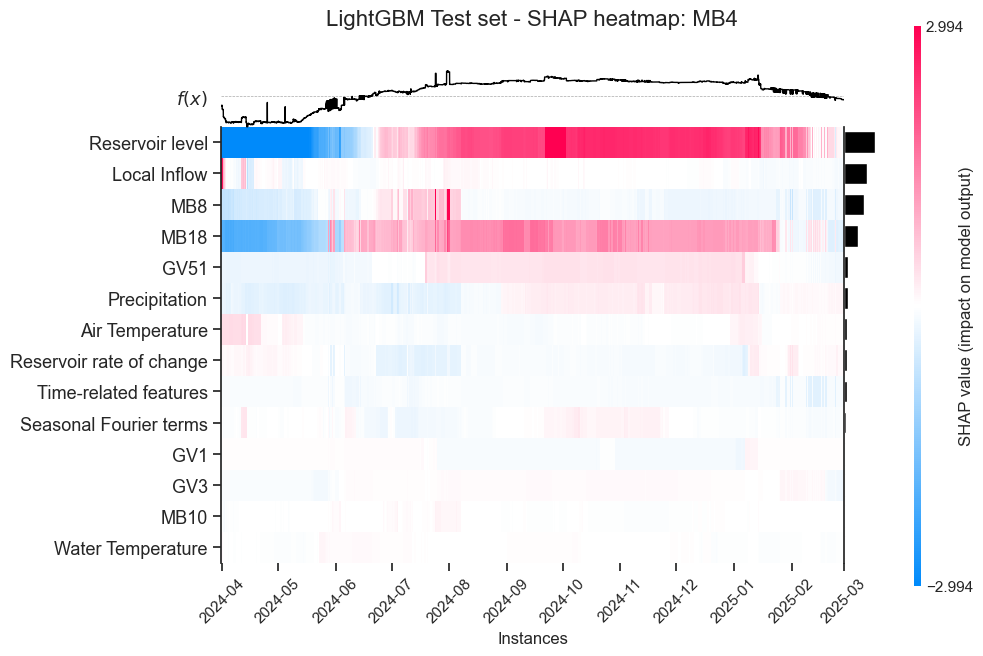

Execution time: 1.49 seconds


In [ ]:
start_time = time.perf_counter()
offset = 0
instances = len(X_test)
original_order = np.arange(len(grouped_explainer_sum[:len(X_test)]))

test_dates = dates[split_index:]
test_dates = test_dates.reset_index(drop=True)

# First create your SHAP heatmap
shap.plots.heatmap(
    grouped_explainer_sum[offset:offset+instances],
    max_display=15,
    feature_values=grouped_explainer_sum.abs.max(0),
    instance_order=original_order,
    show=False
)

# Get the current figure and axes
fig = plt.gcf()
ax = plt.gca()
fig.set_size_inches(10, 10)

# Find indices of the first day of each month
month_start_indices = []
current_month = test_dates[0].month
current_year = test_dates[0].year

for i, date in enumerate(test_dates):
    # If we've moved to a new month, add the index
    if (date.month != current_month or date.year != current_year) and i < instances:
        month_start_indices.append(i)
        current_month = date.month
        current_year = date.year

# Get the corresponding dates
month_start_dates = [test_dates[i] for i in month_start_indices]

# Set the x-tick positions and labels with years
ax.set_xticks(month_start_indices)
ax.set_xticklabels([date.strftime('%Y-%m') for date in month_start_dates], rotation=45)
    
plt.tick_params(axis='x', rotation=45)

# Adjust layout to make room for the rotated labels
plt.title(f"{model_name} Test set - SHAP heatmap: {target}", fontsize=16, y=1.03)
plt.tight_layout()

plt.savefig(f'./visualization/saved_plots/SHAP_heatmap/SHAP_heatmap_{model_name}_{target}.png', dpi=300, bbox_inches='tight')
plt.show()

end_time = time.perf_counter()
print(f"Execution time: {end_time - start_time:.2f} seconds")

<Figure size 640x480 with 0 Axes>

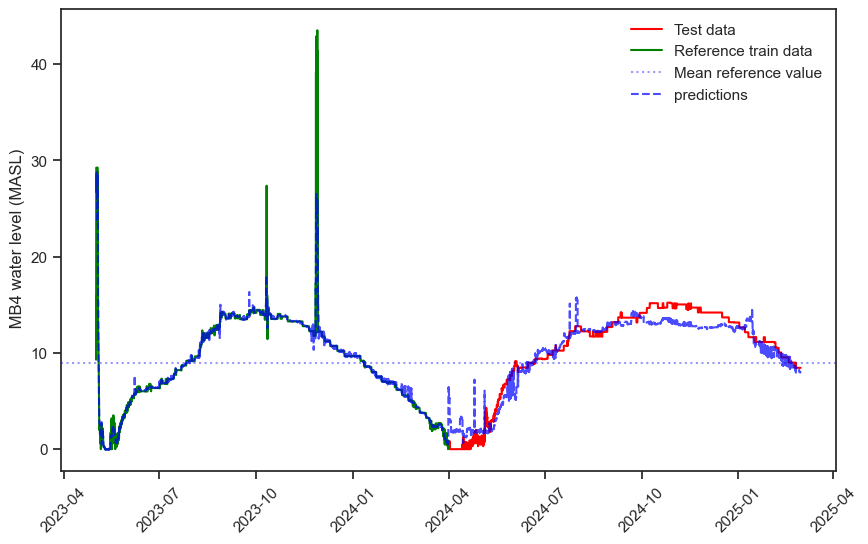

In [ ]:
# Plotting all water levels data (GW pipes + ÖVY reservoir water level)
plt.clf()
plt.figure(figsize=(10, 6))

reference_y_train_data = y_train[split_index-len(y_test):split_index]

plt.plot(dates[split_index:], y_test, color='red', label='Test data')
plt.plot(dates[split_index-len(y_test):split_index], reference_y_train_data, color='green', label='Reference train data')
plt.axhline(y=np.mean(reference_y_train_data), color='blue', alpha=0.4, linestyle=':', label='Mean reference value')

plt.plot(dates[split_index-len(y_test):], all_predictions[split_index-len(y_test):], color='blue', alpha=0.7, linestyle='--', label='predictions')
# plt.axvline(x=dates.iloc[split_index], color='black', alpha=0.4, linestyle=':')
plt.ylabel(f' {target} water level (MASL)')

plt.legend()
plt.xticks(rotation=45)
plt.show()

In [ ]:
print("finished")

finished
